In [16]:
#importing necessary libraries
from datetime import datetime, timedelta,date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline





import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [17]:
#Loading and Processing data to be taken in
train = pd.read_csv('C:/Users/PriyaN/Downloads/Demand-Forecasting sample data/Demand-Forecasting/train.csv')
test = pd.read_csv('C:/Users/PriyaN/Downloads/Demand-Forecasting sample data/Demand-Forecasting/test.csv')
MergedDf = pd.concat([train, test], ignore_index=True, sort=True)
MergedDf.drop(columns=['id'], inplace=True)
MergedDf = MergedDf.pivot_table(values='sales',index='date', aggfunc='sum',columns='store')
ProcessStep1 = pd.DataFrame(MergedDf.to_records())
ProcessStep1['date'] = pd.to_datetime(ProcessStep1['date'])
ProcessStep1['Totals'] = (ProcessStep1['1']+ProcessStep1['2']+ProcessStep1['3']+ProcessStep1['4']+ProcessStep1['5']+ProcessStep1['6']+ProcessStep1['7']+
                           ProcessStep1['8']+ProcessStep1['9']+ProcessStep1['10'])
ProcessStep1 = pd.DataFrame(data=ProcessStep1, columns=['date', 'Totals'])
ProcessStep1 = ProcessStep1.set_index('date')
y = ProcessStep1['Totals'].resample('MS').sum()
ProcessStep2 = y.interpolate(method='linear')
ProcessStep2.replace(0, np.nan, inplace=True)
ProcessStep3 = ProcessStep2.interpolate(method='linear')
FinalDf = pd.DataFrame(ProcessStep3)
FinalDf=FinalDf.reset_index()


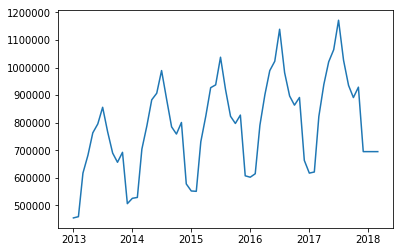

In [19]:
#Express Processed Data In Graphical Format
plt.plot(FinalDf.date,FinalDf.Totals)
plt.show()

In [21]:
#create a new dataframe to model the difference
DiffDf = FinalDf.copy()
#add previous sales to the next row
DiffDf['previous_sales'] = DiffDf['Totals'].shift(1)
#drop the null values and calculate the difference
DiffDf = DiffDf.dropna()
DiffDf['difference'] = (DiffDf['Totals'] - DiffDf['previous_sales'])
DiffDf.head(10)

,date,Totals,previous_sales,difference
1,2013-02-01,459417.0,454904.0,4513.0
2,2013-03-01,617382.0,459417.0,157965.0
3,2013-04-01,682274.0,617382.0,64892.0
4,2013-05-01,763242.0,682274.0,80968.0
5,2013-06-01,795597.0,763242.0,32355.0
6,2013-07-01,855922.0,795597.0,60325.0
7,2013-08-01,766761.0,855922.0,-89161.0
8,2013-09-01,689907.0,766761.0,-76854.0
9,2013-10-01,656587.0,689907.0,-33320.0
10,2013-11-01,692643.0,656587.0,36056.0


In [22]:
#Clean Data for Supervised Learning
SupervisionDf = DiffDf.drop(['previous_sales'],axis=1)

for inc in range(1,15):
    field_name = 'lag_' + str(inc)
    SupervisionDf[field_name] = SupervisionDf['difference'].shift(inc)

SupervisionDf = SupervisionDf.dropna().reset_index(drop=True)

In [24]:
#Using Min Max Scaler make the Data Frame Suitable For LSTM
from sklearn.preprocessing import MinMaxScaler
ModeledDf = SupervisionDf.drop(['Totals','date'],axis=1)
#Split
train_set, test_set = ModeledDf[0:-12].values, ModeledDf[-12:].values

In [25]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [26]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [27]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

C:\Users\PriyaN\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 1/100
36/36 [==============================] - 1s 36ms/step - loss: 0.2161
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.1744
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 0.1505
Epoch 4/100
36/36 [==============================] - 0s 9ms/step - loss: 0.1317
Epoch 5/100
36/36 [==============================] - ETA: 0s - loss: 0.117 - 0s 8ms/step - loss: 0.1167
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.1044
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0940
Epoch 8/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0852
Epoch 9/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0774
Epoch 10/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0705
Epoch 11/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0642
Epoch 12/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0584
Epoch 13/100

In [28]:
y_pred = model.predict(X_test,batch_size=1)
#for multistep prediction, you need to replace X_test values with the predictions coming from t-1

In [29]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[ 0.54720896  1.10628178  0.13866328 -0.10745675 -1.02635392  0.24535439
  -0.05787474 -0.31370458 -0.67437352  0.68397168  0.27578914  0.53846345
   0.65919343  0.98155922  0.16933959]]
[[ 0.53523284  0.68877355  1.10628178  0.13866328 -0.12204966 -1.02635392
   0.24535439 -0.05787474 -0.31370458 -0.67437352  0.68397168  0.27578914
   0.53846345  0.65919343  0.98155922]]
[[ 0.26236731  0.52015228  0.68877355  1.10628178  0.12731349 -0.12204966
  -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352  0.68397168
   0.27578914  0.53846345  0.65919343]]
[[ 0.58587497  0.33428672  0.52015228  0.68877355  1.10768225  0.12731349
  -0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352
   0.68397168  0.27578914  0.53846345]]
[[-0.53370142  0.64253037  0.33428672  0.52015228  0.68467253  1.10768225
   0.12731349 -0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458
  -0.67437352  0.68397168  0.27578914]]
[[-0.38303685 -0.59257833  0.64253037  0.33428672  0.5138293

In [30]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(new_temp_df[-13:].date)
act_sales = list(new_temp_df[-13:].total_sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['predicted_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

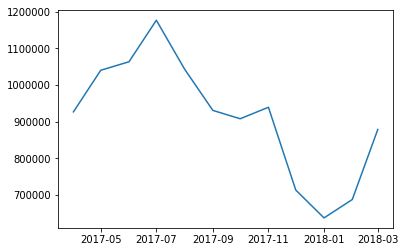

In [33]:
df_show_pred=pd.merge(FinalDf,df_result,on='date',how='left')
plt.plot(df_show_pred.date,df_show_pred.predicted_value)
plt.show()

In [37]:
submission = pd.DataFrame(test)
submission['sales']= df_show_pred.predicted_value

submission.to_csv('submissionlstm.csv',index=False)